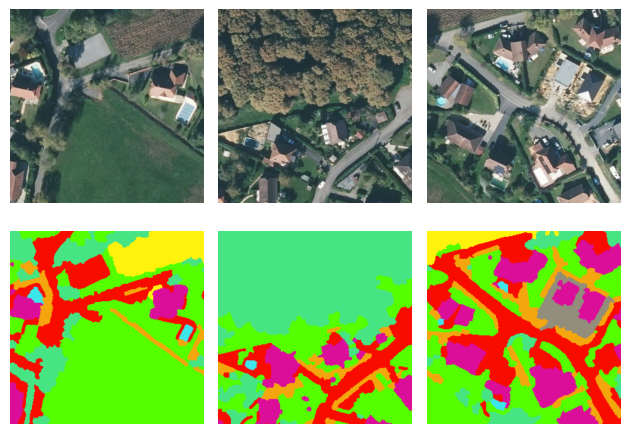

In [1]:
import matplotlib.pyplot as plt
import rasterio
import glob
import warnings
import torch 
import numpy as np 


warnings.filterwarnings('ignore')

train_zone = 'Sauvagnon_64'
images_paths = glob.glob(f"sample/{train_zone}/IMG_*.jpg")
annotations_paths = [path.replace('IMG', 'MSK').replace('jpg', 'tif') for path in images_paths]

flair_data_mapping = torch.tensor([[219, 14, 154],
 [147, 142, 123],
 [248, 12, 0],
 [169, 113, 1],
 [21, 83, 174],
 [25, 74, 38],
 [70, 228, 131],
 [243, 166, 13],
 [102, 0, 130],
 [85, 255, 0],
 [255, 243, 13],
 [228, 223, 124],
 [61, 230, 235],
 [255, 255, 255],
 [138, 179, 160],
 [107, 113, 79],
 [197, 220, 66],
 [153, 153, 255],
 [0, 0, 0]])

for k, (image, annotation) in enumerate(zip(images_paths, annotations_paths)):
    img = rasterio.open(image).read().transpose((1,2,0))
    annot = rasterio.open(annotation).read()[0]
    plt.subplot(2, 3, k + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(2, 3, 3 + k + 1)
    plt.imshow(flair_data_mapping[torch.tensor(annot.astype('int')-1)])
    plt.axis('off')
plt.tight_layout()
plt.show()


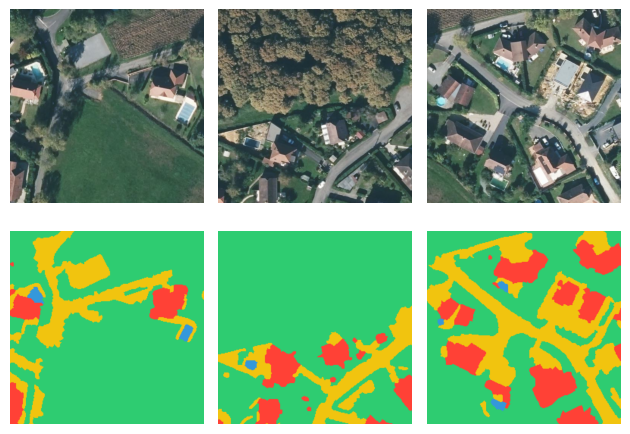

In [2]:
imgs = torch.stack([torch.tensor(rasterio.open(image).read()).float() for image in images_paths])
annots = torch.stack([torch.tensor(rasterio.open(annot).read()[0]).int() for annot in annotations_paths])

mapping = torch.tensor([0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 1, 2, 4, 4, 4, 4, 4, 4])
annots = mapping[annots - 1]
rvb_mapping = torch.tensor([[255, 65, 54], [241, 196, 15], [52, 152, 219], [46, 204, 113], [0, 0, 0]])
annots_rvb = rvb_mapping[annots]

for k, (image, annotation) in enumerate(zip(images_paths, annots_rvb)):
    img = rasterio.open(image).read().transpose((1,2,0))
    plt.subplot(2, 3, k + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(2, 3, 3 + k + 1)
    plt.imshow(annotation)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
model = torch.nn.Sequential(torch.nn.Conv2d(3, 4, 7, padding=3, dilation=1, groups=1, bias=True, padding_mode='reflect', device='cuda'),
                            torch.nn.ReLU()
                           )
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model) # 3 * 4 * 7 * 7 + 4

592

In [6]:
mean, std = imgs.mean((0, 2, 3)), imgs.std((0, 2, 3))
normed_imgs = (imgs - mean[..., None, None]) / std[..., None, None]
normed_imgs = normed_imgs.to('cuda')
annots = annots.to('cuda')

In [16]:
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
accs = []
losses = []
for i in range(500):
    optimizer.zero_grad()
    out = model(normed_imgs)
    pred = torch.argmax(out, dim=1)
    loss = criterion(out, annots)
    loss.backward()
    optimizer.step()
    losses.append(loss)
    accs.append((pred == annots).sum() / (512*512*3) * 100)

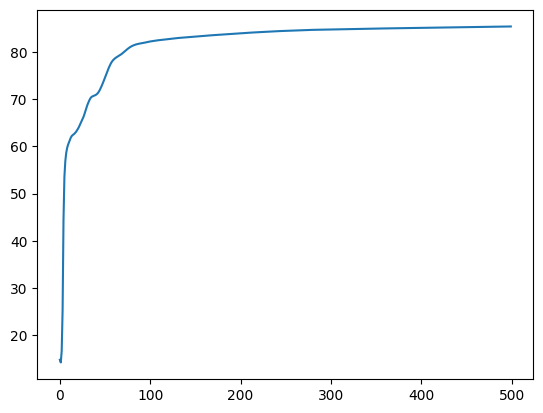

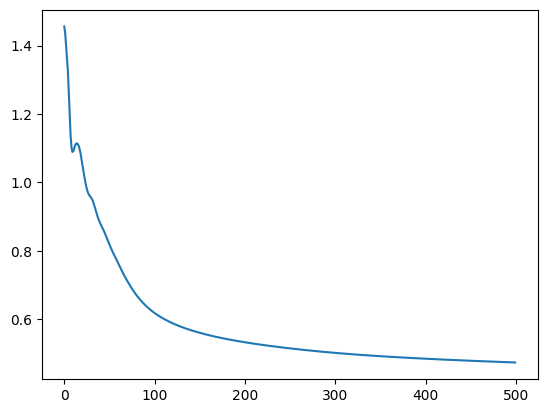

In [17]:
plt.plot([float(acc) for acc in accs])
plt.show()
plt.plot([float(loss) for loss in losses])
plt.show()

In [18]:
model.eval()
with torch.no_grad():
    out = model(normed_imgs)
    pred = torch.argmax(out, dim=1)
pred_rvb = rvb_mapping[pred.cpu()].numpy()

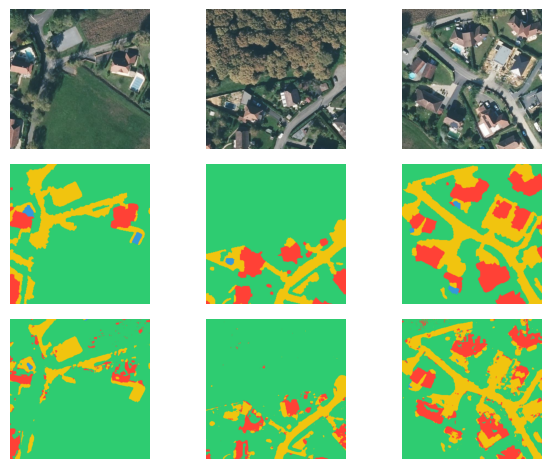

In [19]:
for k, (image, annotation) in enumerate(zip(images_paths, annots_rvb)):
    img = rasterio.open(image).read().transpose((1,2,0))
    plt.subplot(3, 3, k + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(3, 3, 3 + k + 1)
    plt.imshow(annotation)
    plt.axis('off')
    plt.subplot(3, 3, 6 + k + 1)
    plt.imshow(pred_rvb[k])
    plt.axis('off')
plt.tight_layout()
plt.show()